In [3]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [33]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

In [38]:
sess = tf.InteractiveSession()

In [36]:
# once again I only make slight modifications

# define placeholders 
x = tf.placeholder(tf.float32, [None, len(symbol_list) * 100])
y_ = tf.placeholder(tf.float32, [None, len(symbol_list)])

# define trainable variables
W = tf.Variable(tf.random_normal([len(symbol_list) * 100, len(symbol_list)]))
b = tf.Variable(tf.random_normal([len(symbol_list)]))

# we define our model: y = W*x + b
y = tf.matmul(x, W) + b

#MSE:
cost = tf.reduce_sum(tf.pow(y-y_, 2))/(2*1000)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

In [40]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
for epoch in range(20000):
    sess.run(optimizer, feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%1000== 0:
        c = sess.run(cost, feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

Epoch: 1000 cost= 0.040910859
Epoch: 2000 cost= 0.020840863
Epoch: 3000 cost= 0.013389181
Epoch: 4000 cost= 0.009200850
Epoch: 5000 cost= 0.006651346
Epoch: 6000 cost= 0.005042211
Epoch: 7000 cost= 0.003999272
Epoch: 8000 cost= 0.003308342
Epoch: 9000 cost= 0.002842027
Epoch: 10000 cost= 0.002522263
Epoch: 11000 cost= 0.002299956
Epoch: 12000 cost= 0.002143553
Epoch: 13000 cost= 0.002032371
Epoch: 14000 cost= 0.001952614
Epoch: 15000 cost= 0.001894943
Epoch: 16000 cost= 0.001852949
Epoch: 17000 cost= 0.001822181
Epoch: 18000 cost= 0.001799512
Epoch: 19000 cost= 0.001782728
Epoch: 20000 cost= 0.001770250


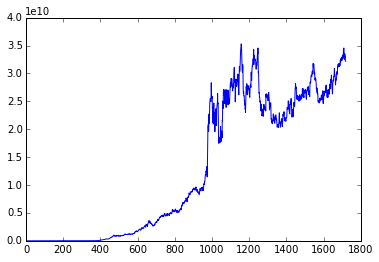

In [60]:
#train results
predict = y
p = sess.run(predict, feed_dict={x: train_ins})
position = 2*((p>0)-.5)
returns= position * train_outs
daily_returns = sum(returns,1)
plot(np.cumprod(daily_returns+1))

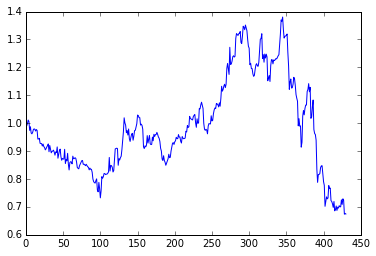

In [61]:
#test results
predict = y
p = sess.run(predict, feed_dict={x: test_ins})
position = 2*((p>0)-.5)
returns= position * test_outs
daily_returns = sum(returns,1)
plot(np.cumprod(daily_returns+1))